## Primer preproste klasifikacije slik
### Ali je na sliki osa, čebela ali kakšen drug insekt?

Pri klasifikaciji slik in na splošno pri globokem učenjum je nepogrešljiva uporaba API-ja za globoko učenje imenovanega `Keras`. Napisan je v Paython-u, in deluje kot "ovoj" (*angl. wrapper*) za knjižnice na nižjih ravneh. Ena izmed najbolj znanih knjižnic, ki jih "ovija" je `TensorFlow`. 

Najbolje je namesiti zadnjo verzijo TensorFlow-a, razen če ga želimo uporabiti v kombinaciji z nekaterimi drugimi knjižnicami, ki zahtevajo točno določeno verzijo.

In [1]:
!pip install tensorflow

Slike, ki jih bomo uporabili za klasifikacijo, je priporočljivo imeti shranjene v mapah, ločnih glede na razred. V našem primeru je struktura direktorijev na disku:

--> data/ <br/>
-----> cebela/ <br/>
-----> osa/ <br/>
-----> ostali_insekti/

V našem primeru imajo vse slike končnico .jpg zato jih lahko preštejemo na sledeči način:

In [2]:
import pathlib
import numpy as np
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

pot = pathlib.Path("data")
st_slik = len(list(pot.glob('*/*.jpg')))
print("Število vseh slik: " + str(st_slik))

Število vseh slik: 3421


Za delo s slikami (odpiranje, prikazovanje, ...) obstaja veliko različnih Python knjižnic. V tem primeru smo uporabili knjižnico `Pillow (PIL)`. Izpišemo nekaj slik iz direktorija *osa*:

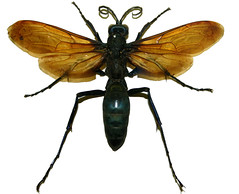

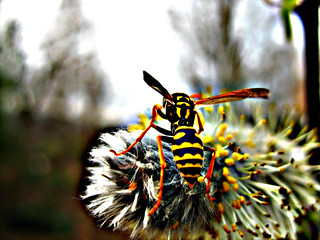

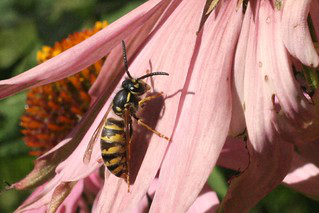

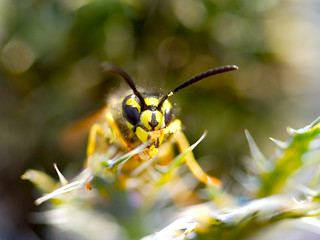

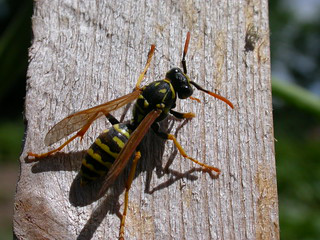

In [3]:
ose = list(pot.glob('osa/*'))
for i in range(5):
    display(PIL.Image.open(str(ose[i])))
    i=i+1

Primeri slik čebel:

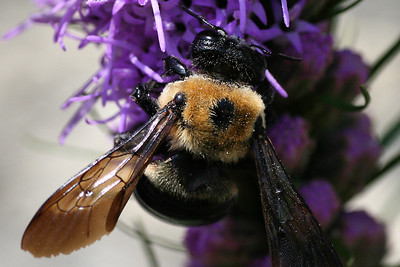

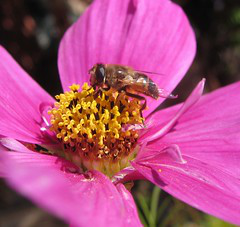

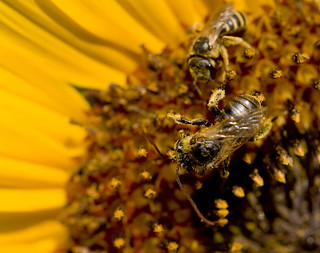

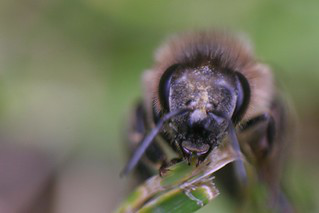

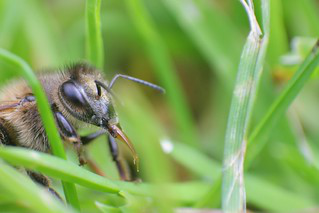

In [4]:
cebele = list(pot.glob('cebela/*'))
for i in range(5):
    display(PIL.Image.open(str(cebele[i])))
    i=i+1

Primeri slik ostalih insektov:

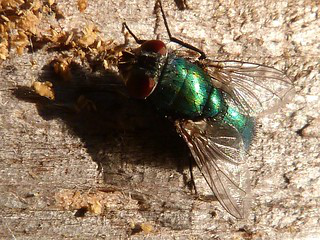

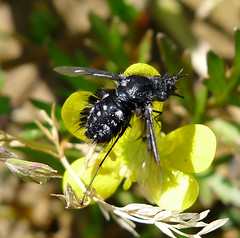

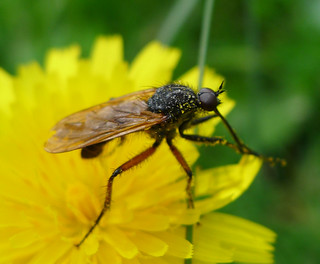

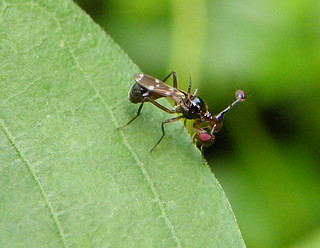

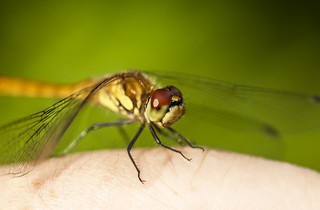

In [5]:
ostali_insekti = list(pot.glob('ostali_insekti/*'))
for i in range(5):
    display(PIL.Image.open(str(ostali_insekti[i])))
    i=i+1

Zbrane slike so lahko različnih velikosti. Pred uporabo jih je potrebno poenotiti na enako velikost. Prav tako je potrebno definirati koliko slik bo vsebovala ena serija (kakšen bo *batch_size*), ki se uporabi za učenje modela. Če imamo zelo malo slik lahko nastavimo velikost serije na 1, kar pomeni da se bo kot vhod vedno uporabila samo ena slika.

In [6]:
img_height = 180
img_width = 180

batch_size = 32

Za lažje nalaganje slik nam *keras* ponuja že pripravljeno funkcijo `image_dataset_from_directory` s katero preberemo slike iz prej opisane strukture direktorijev v dataset (*tf.data.Dataset*). Prav tako nam omogoča da že pri branju pretvorimo slike v enotno velikost in jih razdelimo na učno in validacijsko množico. Pozor - validacijska množica ni enaka testni množici!

In [7]:
train = tf.keras.preprocessing.image_dataset_from_directory(pot,
                                                            validation_split=0.2, #velikost validacijske množice je 20%
                                                            subset="training", #povemo da tu želimo pridobiti slike za učno množico
                                                            seed=123,
                                                            image_size=(img_height, img_width), #spremenimo velikost slik
                                                            batch_size=batch_size) #nastavimo velikost serije

Found 3421 files belonging to 3 classes.
Using 2737 files for training.


In [8]:
validation = tf.keras.preprocessing.image_dataset_from_directory(pot,
                                                                 validation_split=0.2, #velikost validacijske množice je 20%
                                                                 subset="validation", #povemo da tu želimo pridobiti slike za validacijsko množico
                                                                 seed=123,
                                                                 image_size=(img_height, img_width), #spremenimo velikost slik
                                                                 batch_size=batch_size) #nastavimo velikost serije

Found 3421 files belonging to 3 classes.
Using 684 files for validation.


V našem primeru bo 2737 slik uporabljenih za učenje modela, 684 pa za njegovo validiranje. 

Izpis obstoječih izhodnih razredov po abecednem vrstnem redu:

In [9]:
imena_razredov = train.class_names
print(imena_razredov)

['cebela', 'osa', 'ostali_insekti']


Prikaz desetih naključnih slik iz učne množice z njihovimi pripadajočimi razredi:

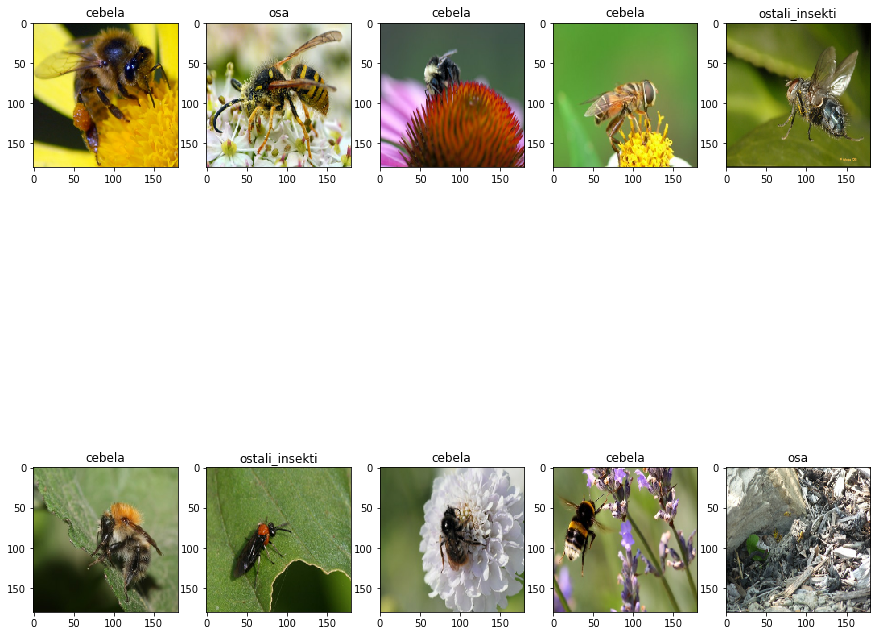

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15)) #nastavimo velikost slik za prikaz
for images, labels in train.take(1):
    for i in range(10): #izpišemo 10 slik
        ax = plt.subplot(2, 5, i + 1) #izpišemo 5 slik v eni vrstici
        plt.imshow(images[i].numpy().astype("uint8")) #prikažemo sliko
        plt.title(imena_razredov[labels[i]]) #pikažemo napis nad sliko

V kakšni obliki so zapisane slike znotraj posamezne serije iz train dataseta?

Število 32 ponazarja velikost serije, 180 predstavlja velikost slik, 3 pa barvne kanale (RGB). V tem primeru so uporabljene barvne slike, če bi bila tu nižja vrednost, bi to pomenilo da so uporabljene slike v sivinah (*grayscale*).

In [11]:
for image_batch, labels_batch in train:
    print(image_batch.shape) 
    print(image_batch) #izpis prve serije (batch-a) 
    print(labels_batch.shape)
    print(labels_batch) #izpis razredov za prvo serijo (batch)
    break

(32, 180, 180, 3)
tf.Tensor(
[[[[ 39.42824    67.5949    114.0949   ]
   [ 44.043056   73.04305   116.95695  ]
   [ 48.72963    77.72963   118.36759  ]
   ...
   [  1.5277957  31.766226   78.76623  ]
   [  3.3875     34.8875     81.8875   ]
   [  1.6546214  33.65462    80.654625 ]]

  [[ 37.288887   65.67084   111.43889  ]
   [ 42.691666   71.691666  114.433334 ]
   [ 49.358334   78.35833   118.691666 ]
   ...
   [ 13.723593   44.981926   91.981926 ]
   [  8.404167   40.033333   87.291664 ]
   [  6.4458356  38.445835   85.9625   ]]

  [[ 29.81713    58.81713   101.62269  ]
   [ 33.194443   62.194443  103.333336 ]
   [ 38.712963   68.07176   107.54398  ]
   ...
   [ 33.550877   65.55087   112.55087  ]
   [ 19.395834   51.395836   99.395836 ]
   [  8.921241   40.92124    89.92124  ]]

  ...

  [[102.043846  100.68506    99.76141  ]
   [130.15271   129.58325   126.36798  ]
   [142.64827   142.50935   137.24548  ]
   ...
   [128.06732   136.35895   127.928406 ]
   [124.47241   132.76404   

Če želimo optimizirat delovanje lahko uporabimo medpomnenje, da ni potrebno slik vedno brati iz diska, ampak jih lahko po prvem branju hranimo v pomnilniku.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = validation.cache().prefetch(buffer_size=AUTOTUNE)

#### Augmentacija (povečanje) podatkov (*angl. data augmentation*)

V primerih ko imamo majhno število podatkov (slik) je za učenje na voljo majhno število instanc, kar lahko vodi do prevelikega prilaganja modela učnim podatkom (*ang. overfitting*) in posledično do slabših rezultatov nad testnimi podatki. Z augmentacijo podatkov ustvarimo dodatne učne podatke iz obstoječih primerov, tako da nad njimi uporabimo naključne transformacije. To omogoča modelu da vidi podatke iz več zornih kotov, kar vodi do večje generalizacije.

Spodnje slike prikazujejo primer augmentacije ene izmed slik iz množice učnih podatkov:

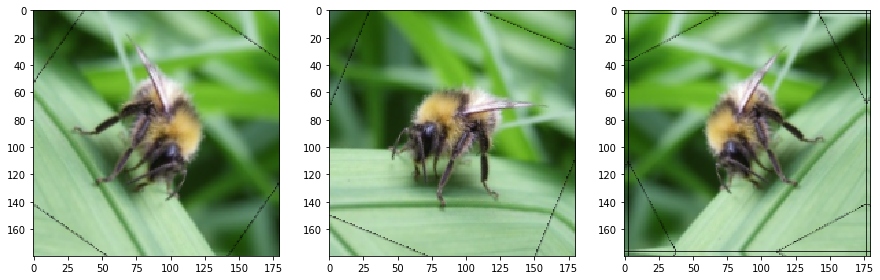

In [13]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ])

plt.figure(figsize=(15, 15))
for images, _ in train.take(1):
    for i in range(3):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))

Enako kot pri klasifikaciji strukturiranih podatkov je tudi pri klasifikaciji slik potrebno številske podatke **standardizirati**. Vsaka RGB slika je namreč zapisanan z vrednostmi v intervalu [0, 255]. Te vrednosti je potrebno pretvoriti na interval [0, 1]. To lahko naredimo na dva načina in sicer preden začnemo graditi model, ali to dodamo kot posebno raven na začetku modela. V našem primeru smo uporabili drugi način, prav tako smo kot posamezno raven modela vključili augmentacijo podatkov.

Za ta primer bomo uporabili model temelječ na **konvolucijskih nevronskih mrežah (CNN)**. Model bodo sestavljali trije konvolucijski bloki z aktivacijsko funkcijo `relu` in `MaxPooling` ravnjo.

In [14]:
from tensorflow.keras.models import Sequential

st_razredov = 3

model = Sequential()
model.add(layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height,img_width,3))) #data augmentation
model.add(layers.experimental.preprocessing.RandomRotation(0.1)) #data augmentation
model.add(layers.experimental.preprocessing.RandomZoom(0.1)) #data augmentation
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))) #standardizacija podatkov
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(st_razredov))

Za optimizacijo modela je tu uporabljen optimizator `Adam`, za izračun funkcije izgube (*angl. loss function*) `SparseCategoricalCrossentropy`, za merjenje uspešnosti modela pa metrika točnosti.

In [15]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

Izpišemo podrobnosti zgrajenega modela:

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_1 (RandomFlip)   (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 180, 180, 3)       0         
_________________________________________________________________
random_zoom_1 (RandomZoom)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)       

Preden zgrajeni model učimo nad testnimi podatki je potrebno še definirati v koliko iteracijah se naj to učenje izvede. To nastavimo z definiranjem števila epoh (*angl. epochs*). Običajno z večjim številom epoh dobimo boljše rezultate, paziti pa moramo, da jih ni preveč, da se model ne prilagodi preveč učnim podatkom.

In [17]:
epochs=10
rezultati = model.fit(train, validation_data=validation, epochs=epochs)

Epoch 1/10
86/86 [==============================] - 66s 764ms/step - loss: 0.9827 - accuracy: 0.5298 - val_loss: 0.8368 - val_accuracy: 0.6374
Epoch 2/10
86/86 [==============================] - 64s 749ms/step - loss: 0.8341 - accuracy: 0.6324 - val_loss: 0.7472 - val_accuracy: 0.7135
Epoch 3/10
86/86 [==============================] - 66s 762ms/step - loss: 0.7606 - accuracy: 0.6770 - val_loss: 0.7230 - val_accuracy: 0.7047
Epoch 4/10
86/86 [==============================] - 69s 805ms/step - loss: 0.7121 - accuracy: 0.7081 - val_loss: 0.6542 - val_accuracy: 0.7178
Epoch 5/10
86/86 [==============================] - 67s 781ms/step - loss: 0.6722 - accuracy: 0.7282 - val_loss: 0.6506 - val_accuracy: 0.7442
Epoch 6/10
86/86 [==============================] - 70s 815ms/step - loss: 0.6574 - accuracy: 0.7373 - val_loss: 0.6285 - val_accuracy: 0.7485
Epoch 7/10
86/86 [==============================] - 69s 808ms/step - loss: 0.5931 - accuracy: 0.7647 - val_loss: 0.5963 - val_accuracy: 0.7646

Izrišemo še grafa, ki prikazujeta kakšni sta bili točnost in loss v posamezni iteraciji učenja modela. Najboljša točnost se giblje blizu 1, najboljši *loss* pa proti 0.

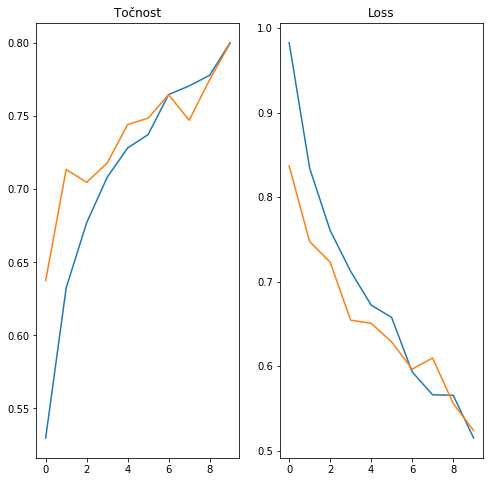

In [18]:
tocnost_train = rezultati.history['accuracy']
tocnost_val = rezultati.history['val_accuracy']

loss_train = rezultati.history['loss']
loss_val= rezultati.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, tocnost_train, label='Učna množica')
plt.plot(epochs_range, tocnost_val, label='Validacijska množica')
plt.title('Točnost')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_train, label='Učna množica')
plt.plot(epochs_range, loss_val, label='Validacijska množica')
plt.title('Loss')
plt.show()

Zgrajeni model preizkusimo še nad testnimi slikami. Teh slik ni bilo v mapi *data*, saj smo jih že prej umaknili v ločeno mapo, da se ne bi uporabilie pri učenju ali vmesni validaciji modela. Vidimo da se je zmotil pri 5 slikah od skupno 14-ih.

cebela, napovedano s 70.21065354347229 % točnostjo


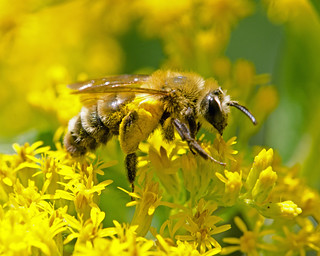

osa, napovedano s 60.97830533981323 % točnostjo


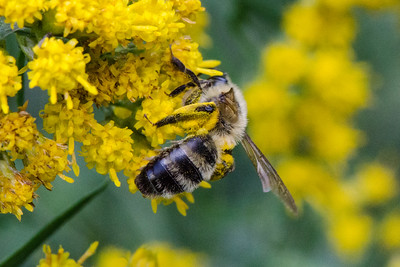

cebela, napovedano s 88.47151398658752 % točnostjo


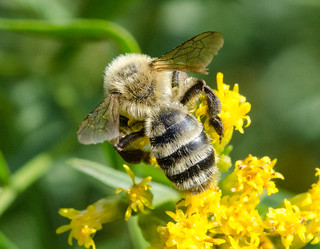

cebela, napovedano s 92.23015308380127 % točnostjo


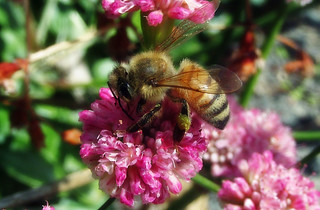

ostali_insekti, napovedano s 95.3604519367218 % točnostjo


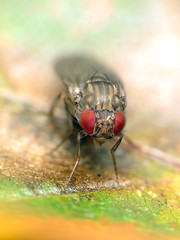

ostali_insekti, napovedano s 55.31131625175476 % točnostjo


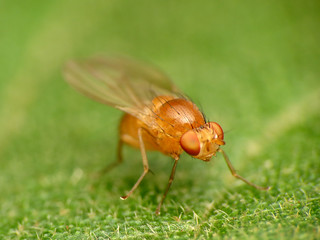

osa, napovedano s 99.67104196548462 % točnostjo


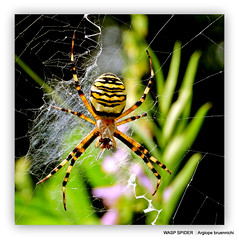

ostali_insekti, napovedano s 98.27897548675537 % točnostjo


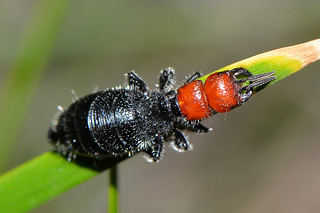

osa, napovedano s 94.88984942436218 % točnostjo


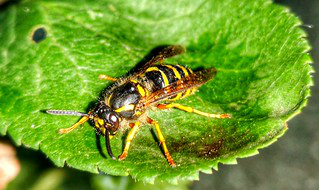

cebela, napovedano s 83.2173764705658 % točnostjo


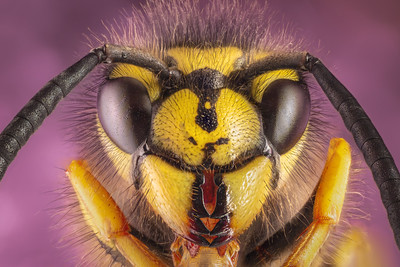

osa, napovedano s 83.12967419624329 % točnostjo


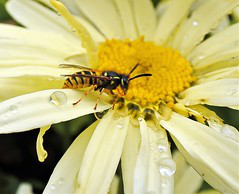

cebela, napovedano s 51.882946491241455 % točnostjo


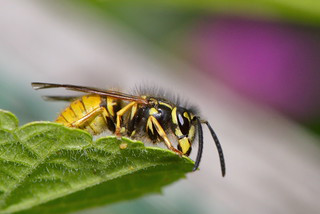

osa, napovedano s 73.4828531742096 % točnostjo


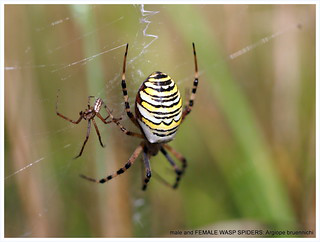

osa, napovedano s 83.53344202041626 % točnostjo


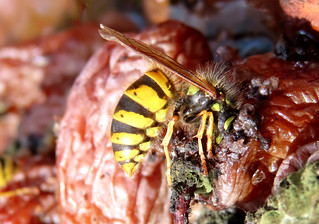

In [19]:
for i in range(1,15):
    img = keras.preprocessing.image.load_img("testne_slike/"+str(i)+".jpg", target_size=(img_height, img_width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    napovedi = model.predict(img_array)
    tocnost = tf.nn.softmax(napovedi[0])

    print(imena_razredov[np.argmax(tocnost)] + ", napovedano s " + str(100 * np.max(tocnost)) + " % točnostjo")
    display(PIL.Image.open(str("testne_slike/"+str(i)+".jpg")))
    i=i+1